In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from collections import defaultdict
from scipy.sparse import dok_matrix, csr_matrix
from sklearn.preprocessing import normalize
import networkx as nx
import itertools
from itertools import islice
from tqdm.notebook import tqdm
from matplotlib.patches import Patch
import scipy as sp
import math
import csv
from collections import OrderedDict
import sys
import matplotlib.cm as cm
import matplotlib.colors as colors

L = 15
df = pd.read_csv("../Titeseq/results/Kds/cleaned_Kds_RBD_ACE2.tsv",
                 dtype={"geno":"str"}, sep="\t")
df["geno_int"] = df.geno.apply(lambda x: int(x, 2))

df = df.set_index("geno_int").reindex(range(0, 2**L)).reset_index()
sequences_int = range(0,2**L)
for ii in range(L):
    df[f"mutation_{ii+1}"] = df.geno.str[ii] == '1'
mutation_names = ['G339D','S371L','S373P','S375F',
                  'K417N',
                  'N440K',
                  'G446S',
                  'S477N','T478K',
                  'E484A',
                  'Q493R',
                  'G496S',
                  'Q498R','N501Y','Y505H'
                 ]

mdct = {m: i for i, m in enumerate(mutation_names)}

colors = ["#66c2bd", "#1b9d9b", "#fc7864", "#d94602", "#8DA0CB","#7570B3","#E78AC3","#E7298A","#A6D854","#66A61E","#FFD92F","#E6AB02","#E5C494","#A6761D","#B3B3B3","#666666"]
fitness = (df[f"log10Kd"]).values.astype('float32')

In [6]:
# mutations considered
ks = range(15)
immune_escape_muts = [4, 6, 9, 10, 11]
binding_muts = [12, 13]

def locus(x):
    st = ""
    for k in ks:
        st += x[k]
    return st

df["locus"] = df.geno.apply(locus).apply(lambda x: int(x, 2))
dfkd = df.groupby("locus").log10Kd.mean()
fitness = dfkd.to_dict()
L = len(ks)
sequences_int = range(0,2**L)

In [7]:
def mutation(s, ii, L):
    """ Return the sequence (in int format) with base s,
        with a somatic mutation at pos ii """
    return s | int(2**(L-1-ii))

nb = 100000

rng = np.random.default_rng()
all_paths, all_mutations = [], []
for _ in range(nb):
    mutations = rng.choice(ks, replace=False, size=15)
    #if (list(mutations).index(12) - list(mutations).index(13)) != 1:
    #    continue
        # only keep paths where 498 follows 501
    
    path = [0]
    for m in mutations:
        path += [mutation(path[-1], m, L)]
    all_mutations += [mutations]
    all_paths += [path]

In [8]:
all_xs, all_ys, switchs_498, switchs_501  = [], [], [], []
for p, m in list(zip(all_paths, all_mutations))[:100]:
    xs, ys = [0], [fitness[0]]
    for idx, mut in zip(p, m):
        if mut in immune_escape_muts:
            xs += [xs[-1] + 1]
            ys += [fitness[idx]]
        if mut  == 12:
            switch_498 = xs[-1]
        elif mut == 13:
            switch_501 = xs[-1]
    xs += [6]
    ys += [fitness[2**L-1]]
    all_xs += [xs]
    all_ys += [ys]
    switchs_498 += [switch_498]
    switchs_501 += [switch_501]

In [9]:
dfx = pd.DataFrame()
dfx["x"] = [x for xs in all_xs for x in xs]
dfx["y"] = [y for ys in all_ys for y in ys]
dfx["mut498"] = [s for xs, s in zip(all_xs, switchs_498) for x in xs]
dfx["mut501"] = [s for xs, s in zip(all_xs, switchs_501) for x in xs]
dfx["trajectory"] = [ii for ii, xs in enumerate(all_xs) for x in xs]
dfx.to_csv("fig4_ultimo.csv")

In [ ]:
fig, ax = plt.subplots()
for x, y, s in zip(all_xs, all_ys, all_switchs):
    ax.plot(x, y, color=sns.color_palette()[s], alpha=0.1)
plt.show()

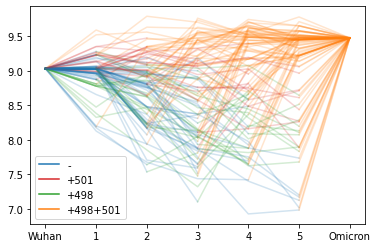

In [53]:
fig, ax = plt.subplots()
α = 0.2
for x, y, s498, s501 in zip(all_xs, all_ys, switchs_498, switchs_501):
    if s498 < s501:
        ax.plot(x[:s498+1], y[:s498+1], color=sns.color_palette()[0], alpha=α)
        ax.plot(x[s498:s501+1], y[s498:s501+1], color=sns.color_palette()[2], alpha=α)
        ax.plot(x[s501:], y[s501:], color=sns.color_palette()[1], alpha=α)
    if s501 < s498:
        ax.plot(x[:s501+1], y[:s501+1], color=sns.color_palette()[0], alpha=α)
        ax.plot(x[s501:s498+1], y[s501:s498+1], color=sns.color_palette()[3], alpha=α)
        ax.plot(x[s498:], y[s498:], color=sns.color_palette()[1], alpha=α)
    if s501 == s498:
        ax.plot(x[:s501+1], y[:s501+1], color=sns.color_palette()[0], alpha=α)
        ax.plot(x[s498:], y[s498:], color=sns.color_palette()[1], alpha=α)

plt.plot([], [], color=sns.color_palette()[0], label="-")
plt.plot([], [], color=sns.color_palette()[3], label="+501")
plt.plot([], [], color=sns.color_palette()[2], label="+498")
plt.plot([], [], color=sns.color_palette()[1], label="+498+501")

ax.set_xticks(list(range(0, 7)))
ax.set_xticklabels(["Wuhan"]+list(range(1, 6)) + ["Omicron"])
ax.legend()
plt.show()